In [1]:
# Vehicle Routing Problem with Time Window
import pandas as pd
import numpy as np
from docplex.mp.model import Model
import matplotlib.pyplot as plt
import re

import sys
import os

In [2]:
rnd = np.random
rnd.seed(0)
dataset_name = "rc101"
length = 15
print(dataset_name, length)
print(f"Dataset: {dataset_name}, Length = {length}")
#file = pd.read_csv("./Data/"+dataset_name+".txt", delim_whitespace=True)
file = pd.read_csv("https://raw.githubusercontent.com/mayashenoi/DO/refs/heads/main/rc101.txt", delim_whitespace=True)
# vrptw_cplex(file, dataset_name, length)
#def vrptw_cplex(dataframe, dataset, length)
dataframe = file
dataset = dataframe

rc101 15
Dataset: rc101, Length = 15


In [3]:
print(dataframe.head())
depot_data = dataframe[0:1]
clients = dataframe[1:length]
length = len(clients)
    
n = len(clients)
Q = 200
N = [i for i in range(1, n + 1)]
V = [0] + N
q = {i: clients["DEMAND"][i] for i in N}
velocity = 20

   CUST_NO.  XCOORD.  YCOORD.  DEMAND  READY_TIME  DUE_DATE  SERVICE_TIME
0         1     40.0     50.0     0.0         0.0     240.0           0.0
1         2     25.0     85.0    20.0       145.0     175.0          10.0
2         3     22.0     75.0    30.0        50.0      80.0          10.0
3         4     22.0     85.0    10.0       109.0     139.0          10.0
4         5     20.0     80.0    40.0       141.0     171.0          10.0


In [4]:
loc_x = rnd.rand(len(V)) * 200  # Randomly generated data if no specific data is being used 
loc_y = rnd.rand(len(V)) * 100
for i in range(len(V)):         # Replacing the dataset information with the randomly generated data
        loc_x[i] = dataframe["XCOORD."][i]
        loc_y[i] = dataframe["YCOORD."][i]


In [5]:
A = [(i, j) for i in V for j in V if i != j]  # List of Arcs
c = {(i, j): round(np.hypot(loc_x[i] - loc_x[j], loc_y[i] - loc_y[j])) for i, j in A}  # Dictionary of distances/costs


In [6]:
T = max(dataframe["READY_TIME"]) ## Recoding the time windows and service times 
service_time = dict()
tw_starts = dict()
tw_ends = dict()
for item in range(1, n + 1):
        tw_s = dataframe["READY_TIME"][i]
        tw_e = dataframe["DUE_DATE"][i]
        service_time[item] = dataframe["SERVICE_TIME"][i]
        tw_starts[item] = tw_s
        tw_ends[item] = tw_e


In [7]:
 # Create a CPLEX model:
mdl = Model('CVRP')

# Define arcs and capacities:
x = mdl.binary_var_dict(A, name='x')
u = mdl.continuous_var_dict(N, ub=Q, name='u')
t = mdl.continuous_var_dict(N, ub=T, name='t')
a = mdl.integer_var_dict(tw_starts, name='a')
e = mdl.integer_var_dict(tw_ends, name='e')
s = mdl.integer_var_dict(service_time, name='s')

# Define objective function:
mdl.minimize(mdl.sumsq(c[i, j] * x[i, j] for i, j in A))


In [8]:
 # Add constraints:
mdl.add_constraints(mdl.sum(x[i, j] for j in V if j != i) == 1 for i in N)  # Each point must be visited
mdl.add_constraints(mdl.sum(x[i, j] for i in V if i != j) == 1 for j in N)  # Each point must be left
mdl.add_indicator_constraints(
mdl.indicator_constraint(x[i, j], u[i] + q[j] == u[j]) for i, j in A if i != 0 and j != 0)
mdl.add_indicator_constraints(
mdl.indicator_constraint(x[i, j], mdl.max(t[i] + c[i, j] + s[i] / 30, a[j]) == t[j]) for i, j in A if i != 0 and j != 0)
mdl.add_indicator_constraints(
mdl.indicator_constraint(x[i, j],  e[j]>=t[j]) for i, j in A if i != 0 and j != 0)
mdl.add_constraints(u[i] >= q[i] for i in N)

[docplex.mp.LinearConstraint[](u_1,GE,20.0),
 docplex.mp.LinearConstraint[](u_2,GE,30.0),
 docplex.mp.LinearConstraint[](u_3,GE,10.0),
 docplex.mp.LinearConstraint[](u_4,GE,40.0),
 docplex.mp.LinearConstraint[](u_5,GE,20.0),
 docplex.mp.LinearConstraint[](u_6,GE,20.0),
 docplex.mp.LinearConstraint[](u_7,GE,20.0),
 docplex.mp.LinearConstraint[](u_8,GE,10.0),
 docplex.mp.LinearConstraint[](u_9,GE,20.0),
 docplex.mp.LinearConstraint[](u_10,GE,30.0),
 docplex.mp.LinearConstraint[](u_11,GE,40.0),
 docplex.mp.LinearConstraint[](u_12,GE,20.0),
 docplex.mp.LinearConstraint[](u_13,GE,10.0),
 docplex.mp.LinearConstraint[](u_14,GE,10.0)]

In [10]:
mdl.parameters.timelimit = 1*60*10 # Add running time limit of 10mins

# Solving model:
solution = mdl.solve(log_output=True)

print(solution.solve_status)  # Returns if the solution is Optimal or just Feasible

Version identifier: 22.1.1.0 | 2023-06-15 | d64d5bd77
CPXPARAM_Read_DataCheck                          1
CPXPARAM_Threads                                 2
CPXPARAM_TimeLimit                               600

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

 1345556 415980    infeasible           4396.0000     2083.7000 10961899   52.60%
Elapsed time = 0.03 sec. (2.40 ticks, tree = 296.10 MB, solutions = 9)
 1345961 416033    infeasible           4396.0000     2084.3500 10963949   52.59%
 1346372 416086     2892.1500    19     4396.0000     2084.3500 10966248   52.59%
 1346826 416143     2900.1500    19     4396.0000     2084.3500 10968324   52.59%
 1347293 416198     4198.6500    18     4396.0000     2084.3500 10970216   52.59%
 1347767 416253     4169.7500     9     4396.0000     2084.3500 10972450   52.59%
 1348200 416350     3144.0500    19     4396.0000     2084.3500 10975620   52.59%
 1348

[(0, 2), (0, 10), (1, 5), (2, 4), (3, 1), (4, 3), (5, 8), (6, 0), (7, 6), (8, 7), (9, 13), (10, 9), (11, 14), (12, 0), (13, 11), (14, 12)]


<module 'matplotlib.pyplot' from '/opt/conda/envs/Python-RT24.1-Premium/lib/python3.11/site-packages/matplotlib/pyplot.py'>

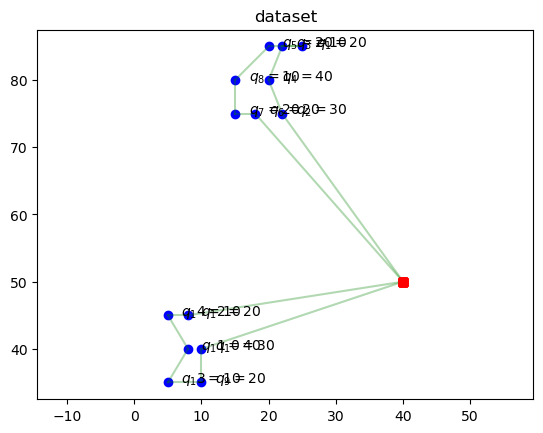

In [14]:
active_arcs = [a for a in A if x[a].solution_value > 0.9]
#print("Dataset=>"+ dataset + " " + str(length))
print(active_arcs) # Returns the arcs of the found solution
    
# Plot solution:
#title = "Dataset=>"+ dataset + " " + str(length)
title="dataset"
plt.title(title)
plt.scatter(loc_x[1:], loc_y[1:], c='b')
for i in N:
        plt.annotate('$q_%d=%d$' % (i, q[i]), (loc_x[i] + 2, loc_y[i]))
for i, j in active_arcs:
        plt.plot([loc_x[i], loc_x[j]], [loc_y[i], loc_y[j]], c='g', alpha=0.3)
        plt.plot(loc_x[0], loc_y[0], c='r', marker='s')
plt.axis('equal')
#plt.savefig("Figure_"+ dataset + "_" + str(length)+".jpg")
#plt.show()
plt